In [1]:
## 0. load packages
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from datetime import datetime
from matplotlib.lines import Line2D

os.chdir('/h/u145/liuxinrui/CROP/')
sys.path.insert(0, '/h/u145/liuxinrui/CROP/')
from core_fct.fct_pre_CROP import aggreg_subreg, load_cropland_weights, remove_timeseries_anomaly, aggreg_region

spcs = ['mai', 'ri1', 'ri2', 'soy', 'wwh', 'swh']
spcs4 = ['mai', 'ric', 'soy', 'whe']
crop_mapping = {'mai': 'maize', 'ric': 'rice', 'soy': 'soybean', 'whe':'wheat'}
impact_models =  ['CYGMA1p74', 'EPIC-IIASA', 'ISAM', 'LDNDC', 'LPJmL', 'PEPIC', 'PROMET', 'SIMPLACE-LINTUL5']

In [2]:
## 1. load parameters

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

from core_fct.fct_loadP_CROP import load_Ndep_ISIMIP3b, load_Nbnf_misc, load_RN_obs
Par = xr.merge([load_Ndep_ISIMIP3b(), load_Nbnf_misc(), load_RN_obs()])
Par['N_bnf'] = Par['N_bnf'].sel(mod_bnf_soy='Ma_2022').squeeze()
Par = Par.drop_dims(['mod_bnf_soy'])
print(Par)

Current date and time: 2025-05-21 21:25:22.768435
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
>>> Running split_region <<<
<xarray.Dataset>
Dimensions:        (reg_land: 292, spc_crop: 6)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
  * spc_crop       (spc_crop) <U3 'mai' 'ri1' 'ri2' 'soy' 'swh' 'wwh'
Data variables:
    N_dep_0        (reg_land) float64 3.291 6.015 7.764 ... 2.856 3.623 2.179
    N_bnf      

In [5]:
## 2. load drivers

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

from core_fct.fct_loadD_CROP import load_Nfertl_hist, load_Ndep_hist
soc = 'histsoc'
For_Nfertl = load_Nfertl_hist().squeeze()
print(For_Nfertl)

Par['N_fertl_0'] = For_Nfertl['N_fertl'].sel(year=2015, drop=True)
print(Par['N_fertl_0'])

For_Ndep = load_Ndep_hist(datasets=['ISIMIP3b']).squeeze()
print(For_Ndep)

For = xr.merge([For_Nfertl, For_Ndep]).sel(year=slice(1960, 2014))

# calculate nitrogen yield responses
func_Geo = lambda x, a, b: a*(np.power(0.99, x)-1)+b*x

def Eq__NI(Var, Par):
    return Var.N_fertl+Var.N_dep+Par.N_bnf

def Eq__RN(Var, Par):
    NI_0 = Par.N_fertl_0+Par.N_dep_0+Par.N_bnf
    RN = func_Geo(Var.NI / 100, Par.g_a, Par.g_b)/func_Geo(NI_0 / 100, Par.g_a, Par.g_b)
    RN = xr.where(RN.spc_crop == 'soy', 1, RN)
    RN = RN.where(RN > 0)
    return RN

NI = Eq__NI(For, Par)
NI.name = 'NI'
For = xr.merge([NI, For])
RN = Eq__RN(For, Par)
RN = RN.fillna(1)
RN.name = 'RN'

print(NI.sel(spc_crop='mai', reg_land=274, year=2014))
print(RN.sel(spc_crop='mai', reg_land=274, year=2014))
print(RN.sel(spc_crop='mai', reg_land=274, year=2014).coords['data_N_fertl'].values)
print(RN.max())
RN.to_netcdf('results/new/RN.nc')

Current date and time: 2025-05-21 21:26:57.542619
Loading 4 datasets for sub-national region
Loading nitrogen_fertl__ISIMIP3b-5crops_sub-national ...
Loading nitrogen_fertl__LUH2-v2h_sub-national ...
Coordinates:
  * year           (year) int64 1850 1851 1852 1853 1854 ... 2012 2013 2014 2015
  * data           (data) object 'v2h' 'v2h_low' 'v2h_high'
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
  * spc_crop       (spc_crop) <U3 'mai' 'ri1' 'ri2' 'soy' 'swh' 'wwh'
    reg_land_name  (reg_land) object 'Afghanistan' 'Aland' ... 'Zimbabwe'
    reg_land_code  (reg_land) object 'AFG' 'ALA' 'ALB' ... 'YEM' 'ZMB' 'ZWE'
Loading nitrogen_fertl__Jagermeyr_2021_sub-national ...
Loading nitrogen_fertl__Adalibieke_2023_sub-national ...
<xarray.Dataset>
Dimensions:        (year: 171, spc_crop: 6, reg_land: 292, data_N_fertl: 6)
Coordinates:
  * reg_land       (reg_land) int64 1 2 3 4 5 6 7 ... 287 288 289 290 291 292
  * year           (year) int64 1850 1851 1852 185

>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<
>>> Running remove_timeseries_anomaly <<<


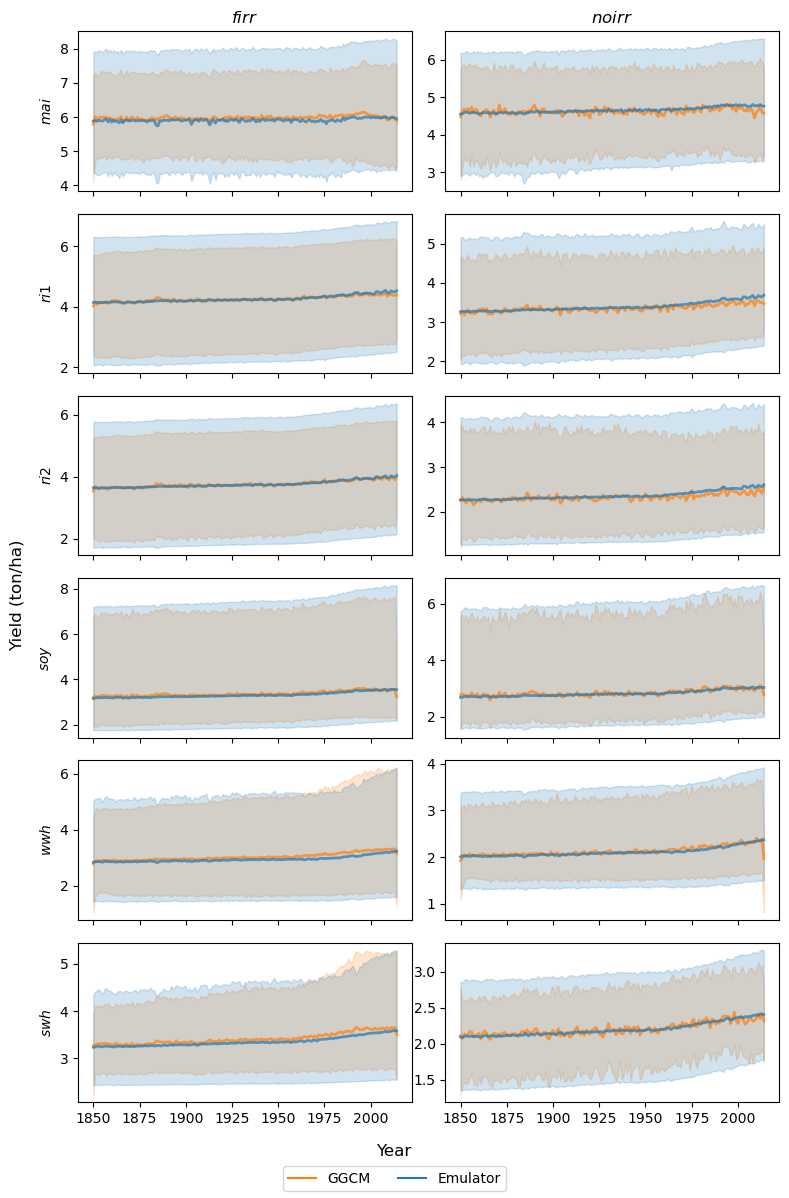

In [ ]:
## 3. compare with GGCM historical yields

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

anomaly_window = 5
anomaly_ratio = 10
yd_threshold = 1.0e-6
rolling_window = 5

dir = '/h/u145/liuxinrui/Data/ISIMIP3b/'
ds0 = []
for irr in ['firr', 'noirr']:
    for mod in impact_models:
        fn_yd = os.path.join(dir, 'yield', mod.lower()+'_yield-'+irr+'_regional_gs.nc')
        yd_hi = (xr.load_dataset(fn_yd)
                .sel(scen='historical', co2sen='default', drop=True)
                .dropna('year', how='all')
                .assign_coords(irr=irr).expand_dims('irr')
                .assign_coords(mod_YD_crop=mod).expand_dims('mod_YD_crop')
                )
        yd_hi['YD'] = yd_hi['YD'].where(yd_hi['YD'] > 0)
        yd_hi['YD'] = remove_timeseries_anomaly(yd_hi['YD'], window=anomaly_window, anomaly_ratio=anomaly_ratio)
        yd_hi['YD'] = yd_hi['YD'].where(yd_hi['YD'] > yd_threshold)
        ds0.append(yd_hi)
YD_in = xr.merge(ds0)

YD = xr.load_dataarray('results/new/YD_global.nc')
YD = YD.sel(year=slice(1850, 2014)).mean('gcm')
YD_in = YD_in['YD'].weighted(load_cropland_weights()).mean('reg_land').mean('gcm')
legend_handles = []
fig, axes = plt.subplots(6, 2, figsize=(8, 12), sharex=True)
for s, spc in enumerate(spcs):
    for i, irr in enumerate(['firr', 'noirr']):
        ax = axes[s, i]
        yd_in = YD_in.sel(spc_crop=spc, irr=irr).to_dataframe()
        yd_out = YD.sel(spc_crop=spc, irr=irr).to_dataframe()
        sns.lineplot(data=yd_in, x='year', y='YD', alpha=0.7, lw=2, ax=ax, c='tab:orange', errorbar=('pi', 100))
        sns.lineplot(data=yd_out, x='year', y='YD', alpha=0.7, lw=2, ax=ax, c='tab:blue', errorbar=('pi', 100))
        
        ax.set_xlabel('')
        if i == 0: 
            ax.set_ylabel(rf'$\it{{{spc}}}$')
        else:
            ax.set_ylabel('')
        if s == 0: ax.set_title(rf'$\it{{{irr}}}$')

fig.supxlabel(r'Year', y=0.03)
fig.supylabel(r'Yield (ton/ha)')
legend_handles = [ Line2D([0, 1], [0, 1], c=color, label=rf'{label}')
                for color, label in [('tab:orange', 'GGCM'), ('tab:blue', 'Emulator')]
                ]  
fig.legend(legend_handles, ['GGCM', 'Emulator'], loc='lower center', ncol=4)
plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()

In [ ]:
## 4. calculate yield

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')

USE_IRR = 'firr'
USE_NI = True
YD = xr.load_dataarray('results/new/YD_noise.nc').sel(year=slice(1960, 2014))
YD_n = YD*RN if USE_NI else YD
del YD

# load irrgation cropland area
from core_fct.fct_loadD_CROP import load_cropland_hist
if USE_IRR == 'all': 
    Ac = load_cropland_hist(irr_flag=True).squeeze()['Ac']
    YD_n = YD_n.weighted(Ac).mean('irr').rename('YD')
if USE_IRR == 'firr': YD_n = YD_n.sel(irr='firr', drop=True).rename('YD')
if USE_IRR == 'noirr': YD_n = YD_n.sel(irr='noirr', drop=True).rename('YD')

# transform sub-regions into national regions
Ac = load_cropland_hist(irr_flag=False).squeeze()['Ac'].sel(year=slice(1960, 2014)).rename('Ac')
ds_YD = xr.merge([YD_n, Ac])
(ds_YD, ) = xr.broadcast(ds_YD)
ds_YD = aggreg_subreg(ds_YD, weight_var='Ac', weight_calc='mean', keep_sub=False)
yd_6 = ds_YD['YD']

#load harvested area
from core_fct.fct_loadD_CROP import load_harvested_hist
area_harv = load_harvested_hist(mod_region='national')

## combine ri1 and ri2
area_ric_harv = area_harv['Ah'].sel(spc_crop=['ri1', 'ri2'])
area_ric_harv = area_ric_harv.where(area_ric_harv > 0).dropna('data_Ah', how='all').squeeze().fillna(0)
yd_ric = yd_6.sel(spc_crop=['ri1', 'ri2']).weighted(area_ric_harv).mean('spc_crop').assign_coords(spc_crop='ric').expand_dims('spc_crop').rename('YD')

## combine swh and wwh
area_whe_harv = area_harv['Ah'].sel(spc_crop=['swh', 'wwh'])
area_whe_harv = area_whe_harv.where(area_whe_harv > 0).dropna('data_Ah', how='all').squeeze().fillna(0)
yd_whe = yd_6.sel(spc_crop=['swh', 'wwh']).weighted(area_whe_harv).mean('spc_crop').assign_coords(spc_crop='whe').expand_dims('spc_crop').rename('YD')

yd_4 = xr.merge([yd_6.sel(spc_crop=['mai', 'soy']), yd_ric, yd_whe])
yd_4.to_netcdf(f'results/new/YD4_{USE_IRR}_N.nc' if USE_NI else f'results/new/YD4_{USE_IRR}.nc')


NameError: name 'datetime' is not defined

In [ ]:
## 5. timeseries of global crop yields

current_datetime = datetime.now()
print(f'\033[1;31;46mCurrent date and time: {current_datetime}\033[0m')     

crop_fao = {
    'Maize (corn)': 'mai',
    'Rice': 'ric',
    'Soya beans': 'soy', 
    'Wheat': 'whe'
}

# Load and prepare FAO data
try:
    df = pd.read_csv(
        os.path.join('/h/u145/liuxinrui/Data/FAO/', f'YD_global.csv'),
        usecols=['Item', 'Year', 'Value']
    ).rename(columns={
        'Item': 'spc_crop',
        'Year': 'year',
        'Value': 'YD'
    })
    
    # Convert to proper types
    df['year'] = df['year'].astype(int)
    for key, val in crop_fao.items():
        df['spc_crop'] = df['spc_crop'].str.replace(key, val, regex=False)
    df['YD'] = df['YD'] / 1000 # coversion to ton/ha
    df.set_index(['spc_crop', 'year'], inplace=True)
    print(df)
    
except Exception as e:
    raise ValueError(f'Error loading FAO data: {str(e)}')

yd4_con = xr.load_dataset(f'results/new/YD4_{USE_IRR}.nc').sel(year=slice(1960, 2014))

wgt = load_cropland_weights(region='national')
weight = xr.concat([wgt.sel(spc_crop=['mai', 'soy']), 
                    wgt.sel(spc_crop='ri1').assign_coords(spc_crop='ric'), 
                    wgt.sel(spc_crop='swh').assign_coords(spc_crop='whe')], 
                    dim='spc_crop')
yd4_con_global = yd4_con.weighted(weight).mean('reg_land')

fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
legend_handles = []
label_handles = []
for s, spc in enumerate(spcs4):
    ax = axes.flat[s]
    ax.set_title(f'{crop_mapping[spc]}')
    sns.lineplot(
        data=yd4_con_global.sel(spc_crop=spc).to_dataframe(),
        x='year',
        y='YD',
        lw=2,
        ls='-',
        color='tab:blue',
        alpha=0.5,
        ax=ax,
        errorbar=('pi', 100),
        label='Constrained',
        legend=False
        )
    sns.lineplot(
        data=df.loc[spc],
        x='year',
        y='YD',
        lw=2,
        ls='--',
        color='tab:brown',
        alpha=0.5,
        label='FAO',
        ax=ax,
        legend=False
    )

    ax.set(xlabel='', ylabel='')
    ax.grid(True, linestyle='--')
    ax.tick_params(axis='both', direction='in')
    if s == 0:
        handles, labels = ax.get_legend_handles_labels()
        label_handles.extend(labels)
        legend_handles.extend(handles)

fig.supxlabel(r'Year', y=0.01)
fig.supylabel(r'Yield (ton/ha)')
fig.legend(legend_handles, label_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.0))
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.97, top=0.85, wspace=0.05, hspace=0.2)
plt.show()

Current date and time: 2025-05-14 11:40:54.524124
                   YD
spc_crop year        
mai      1961  1.9423
         1962  1.9796
         1963  2.0311
         1964  1.9937
         1965  2.1237
...               ...
whe      2019  3.5750
         2020  3.4996
         2021  3.5229
         2022  3.7044
         2023  3.6250

[252 rows x 1 columns]


In [2]:
## 6. match regions

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}
source = 'FAO'
yd_noirr = xr.load_dataarray(f'results/new/YD4_noirr_N.nc').rename('YD').mean(['config', 'gcm']).squeeze()
yd_firr = xr.load_dataarray(f'results/new/YD4_firr_N.nc').rename('YD').mean(['config', 'gcm']).squeeze()
yd_obs = xr.load_dataarray('input_data/observations/crop/yield__{source}_national.nc').rename('YD_in')

from core_fct.fct_loadD_CROP import load_harvested_hist
Ah = load_harvested_hist(crop_species=['mai', 'ric', 'soy', 'whe'], mod_region='national').squeeze()['Ah'].sel(year=slice(1960, 2014)).rename({'data_Ah': 'weight_Ah'})

## only use data available in both datasets
cond = yd_firr.notnull() & yd_noirr.notnull() & yd_obs.notnull() 
yd_firr_global = yd_firr.where(cond).weighted(Ah).mean('reg_land')
yd_noirr_global = yd_noirr.where(cond).weighted(Ah).mean('reg_land')
yd_obs_global = yd_obs.where(cond).weighted(Ah).mean('reg_land')

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)
legend_handles = []
label_handles = []
for s, spc in enumerate(spcs4):
    ax = axes.flat[s]
    ax.set_xlim(1960, 2014)
    ax.set_ylim(0, 8)
    ax.set_title(f'{crop_mapping[spc]}')

    sns.lineplot(
        data=yd_firr_global.sel(spc_crop=spc).to_dataframe(),
        x='year',
        y='YD',
        lw=2,
        ls='-',
        color='tab:green',
        alpha=0.8,
        ax=ax,
        errorbar=('pi', 100),
        label=r'$\it{firr}$',
        legend=False
        )
    sns.lineplot(
        data=yd_noirr_global.sel(spc_crop=spc).to_dataframe(),
        x='year',
        y='YD',
        lw=2,
        ls='-',
        color='tab:orange',
        alpha=0.8,
        ax=ax,
        errorbar=('pi', 100),
        label=r'$\it{noirr}$',
        legend=False
        )
    sns.lineplot(
        data=yd_obs_global.sel(spc_crop=spc).to_dataframe(),
        x='year',
        y='YD_in',
        lw=2,
        ls='--',
        color='tab:brown',
        alpha=0.8,
        label='FAO',
        ax=ax,
        legend=False
    )

    ax.set(xlabel='', ylabel='')
    ax.grid(True, linestyle='--')
    ax.tick_params(axis='both', direction='in')
    if s == 0:
        handles, labels = ax.get_legend_handles_labels()
        label_handles.extend(labels)
        legend_handles.extend(handles)

fig.supxlabel('Year', y=0.01)
fig.supylabel('Yield (ton/ha)')

fig.legend(legend_handles, label_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.0))
plt.subplots_adjust(left=0.08, bottom=0.1, right=0.92, top=0.92, wspace=0.1, hspace=0.2)
plt.show()

Current date and time: 2025-05-23 21:24:10.954945


: 

In [ ]:
## 7.1 top five producers irr

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}

source = 'FAO'
## show the uncertainty from fertilizer
USE_NI = True
dim_avg = ['config', 'gcm', 'data_Ac', 'data_Ah']
fn = f'results/new/YD4_firr_N.nc' if USE_NI else f'results/new/YD4_firr.nc'
yd_firr = xr.load_dataarray(fn).mean(dim_avg).squeeze()
yd_noirr = xr.load_dataarray(fn.replace('firr', 'noirr')).mean(dim_avg).squeeze()
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, 2014)).rename('YD_in')

from core_fct.fct_loadD_CROP import load_harvested_hist
Ah = load_harvested_hist(crop_species=['mai', 'ric', 'soy', 'whe'], mod_region='national').squeeze()['Ah'].sel(year=slice(1960, 2014)).rename({'data_Ah': 'weight_Ah'})

## only use data available in both datasets
cond = (yd_firr.notnull() & yd_noirr.notnull() & yd_obs.notnull())
yd_firr = yd_firr.where(cond).rename('YD_firr')
yd_noirr = yd_noirr.where(cond).rename('YD_noirr')
yd_obs = yd_obs.where(cond).rename('YD_in')

ds_obs = xr.merge([yd_firr, yd_noirr, yd_obs, Ah]).dropna(dim='year', how='all')

AGG = True
if AGG:
    Var0 = []
    Var_mod = ds_obs.rename({'reg_land': 'reg_land_new'})
    for spc in Var_mod.spc_crop.values:
        Var_spc = Var_mod.sel(spc_crop=spc)
        Var_spc = aggreg_region(Var_spc, reg_p[spc], 
                    weight_var={'YD_firr': 'Ah', 'YD_noirr':'Ah', 'YD_in': 'Ah'}, 
                    old_axis='reg_land_new', new_axis='reg_land', time_axis='year', dataset=None
                )
        Var0.append(Var_spc)
    Var_mod = xr.concat(Var0, dim='spc_crop').mean('weight_Ah')

sns.set_style('whitegrid')
legend_handles = []
label_handles = []
fig, axs = plt.subplots(len(spcs4), len(Var_mod.reg_land), figsize=(16, 10), sharex=True)
for s, spc in enumerate(spcs4):
    for r, reg in enumerate(Var_mod.reg_land.values):
        ax = axs[s, r]
        ax.set_xlim(1960, 2014)
        ax.tick_params(axis='both', direction='in')
        ax.xaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        df_reg = Var_mod.sel(spc_crop=spc, reg_land=reg).to_dataframe()
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_firr',
                    c='tab:green',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=r'$\it{firr}$',
                    errorbar=('pi', 100)
        )
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_noirr',
                    c='tab:orange',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=r'$\it{noirr}$',
                    errorbar=('pi', 100)
        )
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_in',
                    c='tab:brown',
                    ls='--',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=source
        )
        ax.set_title(f'{Var_mod['reg_land_name_'+reg_p[spc]].sel(reg_land=reg).values}', y=0.98, fontsize='medium')
        ax.grid(True, linestyle='--')
        if r == 0: 
            ax.set(xlabel='', ylabel=rf'$\it{{{crop_mapping[spc]}}}$')
        else:
            ax.set(xlabel='', ylabel='')

fig.supxlabel(r'Year')
fig.supylabel(r'Yield (ton/ha)')

legend = [ Line2D([0, 1], [0, 1], alpha=0.7, c=color, ls='-', label=rf'$\it{{{irr}}}$')
            for color, irr in [('green', 'firr'), ('orange', 'noirr')]
        ] + [ Line2D([0, 1], [0, 1], alpha=0.7, c='tab:brown', ls='--', label=f'{source}')]
fig.legend(handles=legend, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.0))
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.92, top=0.98, wspace=0.15, hspace=0.2)
plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-05-21 23:14:26.518046
++++++++++++++++++++++++++++++++++++++++++++++++++ 



: 

In [ ]:
## 7.2 top five producers N

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}

source = 'FAO'
## show the uncertainty from fertilizer
USE_NI = True
dim_avg = ['config', 'gcm', 'data_Ac', 'data_Ah']
fn = f'results/new/YD4_all_N.nc' if USE_NI else f'results/new/YD4_firr.nc'
yd_n = xr.load_dataarray(fn).mean(dim_avg).squeeze()
yd_no = xr.load_dataarray(fn.replace('_N', '')).mean(dim_avg).squeeze()
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, 2014)).rename('YD_in')

from core_fct.fct_loadD_CROP import load_harvested_hist
Ah = load_harvested_hist(crop_species=['mai', 'ric', 'soy', 'whe'], mod_region='national').squeeze()['Ah'].sel(year=slice(1960, 2014)).rename({'data_Ah': 'weight_Ah'})

## only use data available in both datasets
cond = (yd_n.notnull() & yd_no.notnull() & yd_obs.notnull())
yd_n = yd_n.where(cond).rename('YD_N')
yd_no = yd_no.where(cond).rename('YD_noN')
yd_obs = yd_obs.where(cond).rename('YD_in')

ds_obs = xr.merge([yd_n, yd_no, yd_obs, Ah]).dropna(dim='year', how='all')

AGG = True
if AGG:
    Var0 = []
    Var_mod = ds_obs.rename({'reg_land': 'reg_land_new'})
    for spc in Var_mod.spc_crop.values:
        Var_spc = Var_mod.sel(spc_crop=spc)
        Var_spc = aggreg_region(Var_spc, reg_p[spc], 
                    weight_var={'YD_N': 'Ah', 'YD_noN':'Ah', 'YD_in': 'Ah'}, 
                    old_axis='reg_land_new', new_axis='reg_land', time_axis='year', dataset=None
                )
        Var0.append(Var_spc)
    Var_mod = xr.concat(Var0, dim='spc_crop').mean('weight_Ah')

sns.set_style('whitegrid')
legend_handles = []
label_handles = []
fig, axs = plt.subplots(len(spcs4), len(Var_mod.reg_land), figsize=(16, 10), sharex=True)
for s, spc in enumerate(spcs4):
    for r, reg in enumerate(Var_mod.reg_land.values):
        ax = axs[s, r]
        ax.set_xlim(1960, 2014)
        ax.tick_params(axis='both', direction='in')
        ax.xaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(3))

        df_reg = Var_mod.sel(spc_crop=spc, reg_land=reg).to_dataframe()
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_N',
                    c='tab:blue',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=r'$\it{firr}$',
                    errorbar=('pi', 100)
        )
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_noN',
                    c='tab:red',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=r'$\it{noirr}$',
                    errorbar=('pi', 100)
        )
        sns.lineplot(
                    data=df_reg,
                    x='year',
                    y='YD_in',
                    c='tab:brown',
                    ls='--',
                    alpha=0.7,
                    lw=2,
                    ax=ax,
                    label=source
        )
        ax.set_title(f'{Var_mod['reg_land_name_'+reg_p[spc]].sel(reg_land=reg).values}', y=0.98, fontsize='medium')
        ax.grid(True, linestyle='--')
        if r == 0: 
            ax.set(xlabel='', ylabel=rf'$\it{{{crop_mapping[spc]}}}$')
        else:
            ax.set(xlabel='', ylabel='')

fig.supxlabel(r'Year', y=0.05)
fig.supylabel(r'Yield (ton/ha)', x=0.02)

legend = [ Line2D([0, 1], [0, 1], alpha=0.7, c=color, ls='-', label=rf'{label}')
            for color, label in [('blue', 'with N'), ('red', 'without N')]
        ] + [ Line2D([0, 1], [0, 1], alpha=0.7, c='tab:brown', ls='--', label=f'{source}')]
fig.legend(handles=legend, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.0))
plt.subplots_adjust(left=0.06, bottom=0.1, right=0.92, top=0.98, wspace=0.15, hspace=0.2)
plt.show()

In [ ]:
## 8. plot global map

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import create_global_map
from core_fct.fct_pre_CROP import stack_dims
plt.rcdefaults()

ind = (1960, 2014)
USE_IRR = 'all'
source = 'FAO'

dist = xr.load_dataarray(f'results/new/dist_{source}_{USE_IRR}_N.nc')
yd = xr.load_dataarray(f'results/new/YD4_{USE_IRR}_N.nc').sel(year=slice(*ind)).mean('year')
if USE_NI:
    yd = stack_dims(yd, ['gcm', 'data_Ah', 'data_Ac', 'config', 'data_N_fertl'], 'new_dims')
else:
    yd = stack_dims(yd, ['gcm', 'data_Ah', 'data_Ac', 'config'], 'new_dims')
yd = yd.where(dist == dist.min('new_dims'))
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(*ind))
fig, axes = plt.subplots(4, 3, figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0)})
for i, spc in enumerate(spcs4):
    ax0 = axes[i, 0]
    if i == 0: ax0.set_title('Crop emulator')
    ax0.set_ylabel(rf'${crop_mapping[spc]}$')
    # Emulated yield
    yd_out = yd.sel(spc_crop=spc)
    ax0, cf = create_global_map(yd_out, 
                region='national', 
                levels=np.linspace(1, 10, 10), 
                ax=ax0, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax0.tick_params(axis='both', which='major', labelsize=8)

    ax1 = axes[i, 1]
    if i == 0: ax1.set_title(source)
    yd_in = yd_obs.sel(spc_crop=spc, year=slice(*ind)).mean('year')
    ax1, cf = create_global_map(yd_in, 
                region='national',
                levels=np.linspace(1, 10, 10), 
                ax=ax1, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax1.tick_params(axis='both', which='major', labelsize=8)

    ax2 = axes[i, 2]
    yd_diff = (yd_out - yd_in) / yd_in * 100
    if i == 0: ax2.set_title('Relative yield difference')
    ax2, cf2 = create_global_map(yd_diff, 
                region='national',
                levels=np.linspace(-100, 100, 11), 
                ax=ax2, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'seismic'},
                colorbar_kwargs={'extend': 'both', 'extendrect': False}
            )
    ax2.tick_params(axis='both', which='major', labelsize=8)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.15, wspace=0.15)
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.53, 0.01])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax1, label=rf'Yield (ton/ha)', orientation='horizontal', extend='max', ticks=np.linspace(1, 10, 10), extendrect=False)
cbar_ax2 = fig.add_axes([0.65, 0.05, 0.25, 0.01]) 
fig.colorbar(cf2, cax=cbar_ax2, label=rf' Relative yield difference (%)', orientation='horizontal', ticks=np.linspace(-100, 100, 11), extendrect=False)
plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-05-28 20:54:39.369886
++++++++++++++++++++++++++++++++++++++++++++++++++ 



: 

In [ ]:
## 9. overall alignment

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import stack_dims
from sklearn.metrics import mean_squared_error

reg_p = {'mai': 'Maize', 'ric': 'Rice', 'soy': 'Soybean', 'whe': 'Wheat'}

source = 'FAO'
USE_IRR = 'noirr'
USE_NI = False
fn = f'results/new/YD4_{USE_IRR}_N.nc' if USE_NI else f'results/new/YD4_{USE_IRR}.nc'
yd = xr.load_dataarray(fn).sel(year=slice(1960, 2014))
yd_obs = xr.load_dataarray(f'input_data/observations/crop/yield__{source}_national.nc').sel(year=slice(1960, 2014)).rename('YD_in')
## the order of stacked dimensions should be the same
if USE_NI:
    yd = stack_dims(yd, ['gcm', 'data_Ah', 'data_Ac', 'config', 'data_N_fertl'], 'new_dims')
else:
    yd = stack_dims(yd, ['gcm', 'data_Ah', 'data_Ac', 'config'], 'new_dims')

fn_dist = f'results/new/dist_{source}_{USE_IRR}_N.nc' if USE_NI else f'results/new/dist_{source}_{USE_IRR}.nc'
if os.path.exists(fn_dist):
    print(f'loading {fn_dist}')
    dist = xr.load_dataarray(fn_dist)
else:
    dist = xr.DataArray(
        np.nan * np.zeros((len(yd.reg_land), len(yd.spc_crop), len(yd.new_dims))),
        dims=[ 'reg_land', 'spc_crop', 'new_dims'],
        coords={'reg_land': yd.reg_land.values, 'spc_crop': yd.spc_crop.values, 'new_dims': yd.new_dims.values},
        name='RRMSE'
    )
    for data in yd.new_dims.values:
        for reg in yd.reg_land.values:
            for spc in yd.spc_crop.values:
                yd_config = yd.sel(spc_crop=spc, reg_land=reg, new_dims=data, drop=True)
                if yd_config.notnull().sum() == 0: continue
                yd_obs_reg = yd_obs.sel(spc_crop=spc, reg_land=reg, drop=True)
                if yd_obs_reg.notnull().sum() == 0: continue
                cond = (yd_config.notnull() & yd_obs_reg.notnull())
                yd_config = yd_config.where(cond).dropna(dim='year')
                yd_obs_reg = yd_obs_reg.where(cond).dropna(dim='year')
                if len(yd_obs_reg) == 0: continue
                dist.loc[{'spc_crop':spc, 'reg_land': reg, 'new_dims': data}] = mean_squared_error(yd_config, yd_obs_reg) / yd_obs_reg.mean().values
    dist.to_netcdf(fn_dist)

qt_val = 1.0
for reg in yd.reg_land.values:
    fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True)
    for spc in yd.spc_crop.values:
        ax = axs.flat[spcs4.index(spc)]
        ax.set_xlim(1960, 2014)
        ax.tick_params(axis='both', direction='in')
        ax.xaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
        ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
        ax.set_title(f'{crop_mapping[spc]}')
        
        dist_reg = dist.sel(spc_crop=spc, reg_land=reg, drop=True)
        qt = dist_reg.quantile(qt_val, dim='new_dims')
        cond = ((dist_reg >= 0) & (dist_reg <= qt))
        yd_reg = yd.sel(spc_crop=spc, reg_land=reg, drop=True)
        yd_reg = yd_reg.where(cond).dropna('new_dims', how='all')
        yd_obs_reg = yd_obs.sel(spc_crop=spc, reg_land=reg, drop=True)
        
        sns.lineplot(data=yd_reg.to_dataframe(), x='year', y='YD', ax=ax, color='tab:blue', lw=2, alpha=0.7, errorbar=('pi', 100))
        sns.lineplot(data=yd_obs_reg.to_dataframe(), x='year', y='YD_in', ax=ax, color='tab:brown', lw=2, ls='--', alpha=0.7)
        ax.text(0.5, 0.95, f'{qt_val} RMSE quantile: {qt:.2f}', ha='center', va='center', transform=ax.transAxes, fontsize=10)
        ax.set(xlabel='', ylabel='')
        ax.grid(True, linestyle='--', alpha=0.5)
    fig.supxlabel(r'Year', x=0.5, y=0.01)
    fig.supylabel(r'Yield (ton/ha)', x=0)
    fig.suptitle(f'{yd.reg_land_name.sel(reg_land=reg, drop=True).values}')
    pic = f'results/new/fig/YD_{source}_{USE_IRR}_{qt_val}_{reg}_N.png' if USE_NI else f'results/new/fig/YD_{source}_{USE_IRR}_{qt_val}_{reg}.png' 
    plt.savefig(pic, dpi=300, bbox_inches='tight')
    plt.close()

Current date and time: 2025-05-19 14:33:59.506420


FileNotFoundError: [Errno 2] No such file or directory: b'/h/u145/liuxinrui/CROP/input_data/observations/crop/yield__{source}_national.nc'

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-05-28 22:04:38.465031
++++++++++++++++++++++++++++++++++++++++++++++++++ 

>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...
>>> Running create_global_map <<<
>>> Running aggreg_subreg <<<
Ploting contour map ...


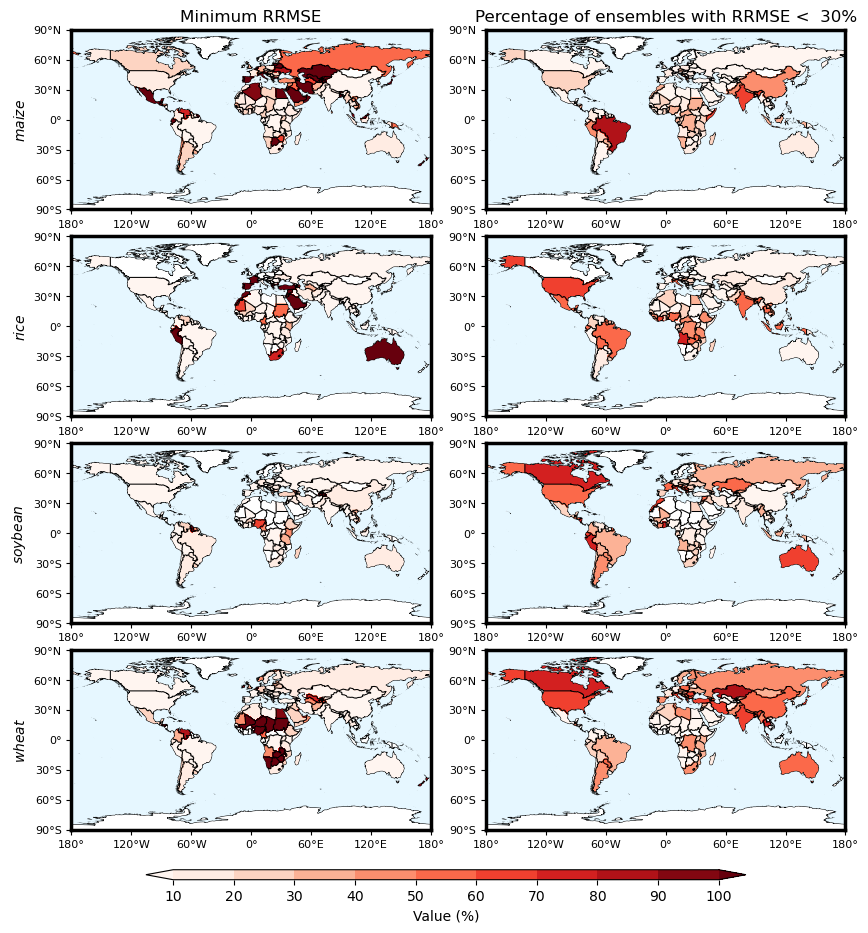

In [13]:
## 10. plot RRMSE

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

from core_fct.fct_pre_CROP import create_global_map
plt.rcdefaults()

USE_IRR = 'all'
source = 'FAO'

yd_n = xr.load_dataarray(f'results/new/dist_{source}_{USE_IRR}_N.nc')
yd1 = yd_n.min('new_dims')
thresh = 0.3
yd2 = xr.where(yd_n < thresh, 1, 0).sum('new_dims') / yd_n.notnull().sum('new_dims')
fig, axes = plt.subplots(4, 2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.0)})
for i, spc in enumerate(spcs4):
    ax0 = axes[i, 0]
    qt = 0.0
    if i == 0: ax0.set_title(f'Minimum RRMSE')
    ax0.set_ylabel(rf'${crop_mapping[spc]}$')
    # Emulated yield
    ax0, cf = create_global_map(yd1.sel(spc_crop=spc) * 100, 
                region='national', 
                levels=np.linspace(10, 100, 10), 
                ax=ax0, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax0.tick_params(axis='both', which='major', labelsize=8)

    ax1 = axes[i, 1]
    
    if i == 0: ax1.set_title(f'Percentage of ensembles with RRMSE < {thresh*100: .0f}%')
    ax1, cf = create_global_map(yd2.sel(spc_crop=spc) * 100, 
                region='national',
                levels=np.linspace(10, 100, 10), 
                ax=ax1, 
                cb_on=False, 
                contourf_kwargs={'cmap': 'Reds'}, 
                colorbar_kwargs={'extend': 'max', 'extendrect': False}
            )
    ax1.tick_params(axis='both', which='major', labelsize=8)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=0.15, wspace=0.15)
cbar_ax1 = fig.add_axes([0.2, 0.05, 0.6, 0.01])  # [left, bottom, width, height]
fig.colorbar(cf, cax=cbar_ax1, label=rf'Value (%)', orientation='horizontal', extend='max', ticks=np.linspace(10, 100, 10), extendrect=False)
plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++
Current date and time: 2025-05-28 21:35:09.413867
++++++++++++++++++++++++++++++++++++++++++++++++++ 



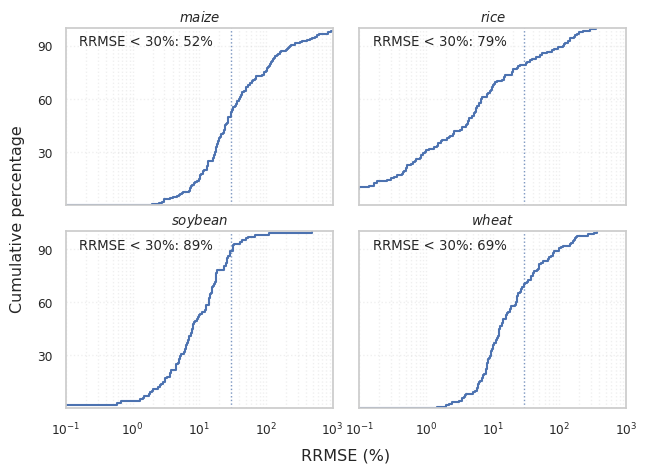

In [4]:
## 11. plot the density of RRMSE

current_datetime = datetime.now()
print('+'*50)
print(f'Current date and time: {current_datetime}')
print('+'*50, '\n')

plt.rcdefaults()

USE_IRR = 'all'
source = 'FAO'
yd_n = xr.load_dataarray(f'results/new/dist_{source}_{USE_IRR}_N.nc').min('new_dims')*100

# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=0.8)
plt.rcParams['axes.unicode_minus'] = False

# Color palette for irrigation types
palette = {'firr': 'green', 'noirr': 'orange'}

fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True, gridspec_kw={'hspace': 0.15, 'wspace': 0.1, 'left': 0.1, 'bottom': 0.12})
legend_handles = []
label_handles = []
for s, spc in enumerate(spcs4):
    ax = axes.flat[s]
    ax.set_title(rf'${crop_mapping[spc]}$', pad=10, fontsize='medium', y=0.96)
    ax.set_xscale('log')
    ax.set_xlim(0.1, 1000)
    ax.set_ylim(0, 100)
    ax.grid(True, which='both', ls=':', alpha=0.3)
    ax.xaxis.set_major_locator(ticker.LogitLocator())
    ax.xaxis.set_major_locator(ticker.FixedLocator([0.1, 1, 10, 100, 1000]))
    ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_locator(ticker.FixedLocator([30, 60, 90]))
    
    val = 30
    yd_values = yd_n.sel(spc_crop=spc, drop=True).dropna('reg_land').values.ravel()
    pt = np.sum(yd_values < val) / yd_values.size
    
    # Plot CDF using Seaborn
    sns.ecdfplot(
        data=yd_values,
        ax=ax,
        stat='percent',
        linewidth=1.5,
    )
    
    # Add percentile line
    ax.axvline(
        val, 
        linestyle=':', 
        linewidth=1,
        alpha=0.7
    )

    ax.text(0.05, 0.9, rf'RRMSE < {val}%: {pt*100:.0f}%', transform=ax.transAxes)
    ax.set_ylabel('')

# 🔹 Legend & Title
fig.supylabel('Cumulative percentage', fontsize='large')
fig.supxlabel(r'RRMSE (%)', fontsize='large')
plt.show()

In [23]:
## 12. check data

from core_fct.fct_pre_CROP import print_values_by_threshold

print_values_by_threshold(yd2.sel(spc_crop='whe') * 100, above=30)

>>> Running print_values_by_threshold <<<
Coordinates where values > 30 or < None:
1. reg_land: 3 | Value: 34.20690
2. reg_land: 11 | Value: 44.85057
3. reg_land: 15 | Value: 50.90805
4. reg_land: 20 | Value: 35.04000
5. reg_land: 23 | Value: 63.91478
6. reg_land: 30 | Value: 48.18000
7. reg_land: 34 | Value: 35.27586
8. reg_land: 43 | Value: 53.31034
9. reg_land: 45 | Value: 43.31754
10. reg_land: 48 | Value: 79.98000
11. reg_land: 72 | Value: 35.84000
12. reg_land: 76 | Value: 38.14000
13. reg_land: 77 | Value: 49.02796
14. reg_land: 95 | Value: 42.26000
15. reg_land: 104 | Value: 68.34483
16. reg_land: 109 | Value: 42.18009
17. reg_land: 118 | Value: 30.52000
18. reg_land: 120 | Value: 61.14000
19. reg_land: 122 | Value: 62.75862
20. reg_land: 127 | Value: 64.32000
21. reg_land: 130 | Value: 65.97701
22. reg_land: 132 | Value: 38.68966
23. reg_land: 133 | Value: 86.40000
24. reg_land: 134 | Value: 33.55526
25. reg_land: 144 | Value: 49.98668
26. reg_land: 147 | Value: 34.46000
27. r